In [1]:
import pandas as pd
import numpy as np
import json
from datetime import datetime

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.offline import plot
from plotly.graph_objs import Scatter, Data, Box, Bar
from plotly.graph_objs import Scattergl
init_notebook_mode() # run at the start of every ipython notebook to use plotly.offline
                     # this injects the plotly.js source files into the notebook
from plotly.tools import FigureFactory as FF
import plotly.plotly as py
import plotly.graph_objs as go

%matplotlib inline
import matplotlib as plt
plt.style.use('ggplot')
import cufflinks as cf
cf.set_config_file(offline=True, world_readable=True, theme='ggplot')

# Get JSON data from EtherScan.io API

In [7]:
import urllib3, json, certifi
import pandas as pd
import shutil

def transactions():
    http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED',  # Force certificate check.
                               ca_certs=certifi.where(),  # Path to the Certifi bundle.
                               )

    dao_address = '0xbb9bc244d798123fde783fcc1c72d3bb8c189413'
    etherscan_url = 'https://api.etherscan.io/api?module=account&action=txlist&address=' + dao_address + '&sort=asc'

    with open('sample.json', 'w') as f, http.request('GET', etherscan_url, preload_content=False) as r:
        string_r = r.data.decode('utf-8')
        obj = json.loads(string_r)
        json.dump(obj, f, sort_keys=True, indent=4)
    print(obj['message'])

transactions()

OK


#  Load Transactions from .json

In [3]:
jsondata = pd.read_json("sample.json")
jsondata.head()

,message,result,status
0,OK,"{'transactionIndex': '0', 'contractAddress': '...",1
1,OK,"{'transactionIndex': '3', 'contractAddress': '...",1
2,OK,"{'transactionIndex': '1', 'contractAddress': '...",1
3,OK,"{'transactionIndex': '5', 'contractAddress': '...",1
4,OK,"{'transactionIndex': '6', 'contractAddress': '...",1


In [147]:
jsondata.result[10000]

{'blockHash': '0x8d2a0440bb5a78f075ee906eb661fcff85e2a84e935791c5e55460187f63c395',
 'blockNumber': '1458293',
 'confirmations': '59413',
 'contractAddress': '',
 'cumulativeGasUsed': '44091',
 'from': '0x9e49df12d7b2636508fff7b666736a5c9b12a2d9',
 'gas': '144091',
 'gasPrice': '20000000000',
 'gasUsed': '44091',
 'hash': '0x9c3b35b3f23e83c1b095fa594e09c57f18453ec12ec4fd73aac781be900c7ca9',
 'input': '0x',
 'nonce': '2',
 'timeStamp': '1462404332',
 'to': '0xbb9bc244d798123fde783fcc1c72d3bb8c189413',
 'transactionIndex': '0',
 'value': '2000000000000000000000'}

In [6]:
trans = pd.DataFrame(dict(jsondata.result))
trans = trans.transpose()
trans['value'] = trans.value.astype(float)
trans['blockNumber'] = trans.blockNumber.astype(int)
trans['value_ether'] = trans.value / 1e18
trans['gasPrice'] = trans.gasPrice.astype(float)
trans['gasUsed'] = trans.gasUsed.astype(float)
trans['value_cum'] = trans.value_ether.cumsum()
trans.cumulativeGasUsed = trans.cumulativeGasUsed.astype(float)
# Note the final block of the 1 ETH to 100 tokens
blockEnd_phaseOne = 1520860
# Only get transactions up to this block, ignore the rest
trans = trans[trans.blockNumber <= 1520860]
trans.head()

,blockHash,blockNumber,confirmations,contractAddress,cumulativeGasUsed,from,gas,gasPrice,gasUsed,hash,input,nonce,timeStamp,to,transactionIndex,value,value_ether,value_cum
0,0x9a9d1fc252e816fd047b85b6c1028317ecc0bf3db18d...,1429008,119478,,47080.0,0x931f12be72a1d106408af5ced7e1b7af0bc864ae,49900,2.000000e+10,47080.0,0x18aa650060a1434310a05824e1df6e29a6904f29839e...,0x095ea7b3000000000000000000000000fbb1b73c4f0b...,0,1461984277,0xbb9bc244d798123fde783fcc1c72d3bb8c189413,0,0.0,0.0,0.0
1,0x9a9d1fc252e816fd047b85b6c1028317ecc0bf3db18d...,1429008,119478,,136160.0,0xb504e60998c6f354a0794abd91d85e8bc8436211,49900,2.000000e+10,47080.0,0xe71a87b83e054f616e8b1f4884b905d9a347b64433bb...,0x095ea7b3000000000000000000000000fbb1b73c4f0b...,0,1461984277,0xbb9bc244d798123fde783fcc1c72d3bb8c189413,3,0.0,0.0,0.0
2,0x41a0f3f494329c60c88ae92bf6fc6f35c389e27f53f3...,1429009,119477,,68080.0,0xe0b8bdfddba2b1636c9a975f9e9759169fddee45,49900,2.000000e+10,47080.0,0xc750552b741c499b073dc58d7148c0e8f24c9b4e0a94...,0x095ea7b3000000000000000000000000fbb1b73c4f0b...,0,1461984318,0xbb9bc244d798123fde783fcc1c72d3bb8c189413,1,0.0,0.0,0.0
3,0x41a0f3f494329c60c88ae92bf6fc6f35c389e27f53f3...,1429009,119477,,199599.0,0x2c30cdad7abdeedb44657a7b46827fc38af12203,49900,2.000000e+10,47080.0,0x7a47fdb185d89ab843e71d53702b6ea172378007cf12...,0x095ea7b3000000000000000000000000fbb1b73c4f0b...,0,1461984318,0xbb9bc244d798123fde783fcc1c72d3bb8c189413,5,0.0,0.0,0.0
4,0x41a0f3f494329c60c88ae92bf6fc6f35c389e27f53f3...,1429009,119477,,246679.0,0xd97fdc4af28008c219639401f661369b704e7bbc,49900,2.000000e+10,47080.0,0x5ab9ac02611a1f0652706e4f43515840d1dc33a22b87...,0x095ea7b3000000000000000000000000fbb1b73c4f0b...,0,1461984318,0xbb9bc244d798123fde783fcc1c72d3bb8c189413,6,0.0,0.0,0.0


# How much ether total?

In [5]:
EthToBtc = 0.025
BtcToUsd = 456.25

In [5]:
total_ether = trans.value_ether.sum()
print('ETH {} '.format(total_ether))
print('BTC {}'.format(total_ether * EthToBtc))
print('USD {}'.format(total_ether * EthToBtc * BtcToUsd))

ETH 10264539.206572307 
BTC 256613.4801643077
USD 117079900.32496539


# How many total transactions and unique addresses?

In [6]:
total_transactions = len(trans)
total_transactions

42024

In [7]:
total_addresses = len(trans['from'].unique())
total_addresses

14408

In [8]:
trans.value_ether.describe()

count     42024.000000
mean        244.254217
std        2250.690264
min           0.000000
25%           1.000000
50%          10.000000
75%          85.000000
max      201911.999580
Name: value_ether, dtype: float64

In [9]:
trace = go.Scatter(
    x=trans.blockNumber, 
    y=trans.value_cum,
    name='Transaction Values',
)
data = [trace]
layout = go.Layout(
    title="Cummulative Transaction Volume",
    xaxis=go.XAxis(
        title='Block number',
    ),
    yaxis=go.YAxis(
        title='Amount inversted (Ether)',
    ),
)
fig = go.Figure(data=data, layout=layout)

iplot(fig)
# py.iplot(fig, filename='DAO_plots/cummulative_trans')

# Looking at the number of transactions per address

In [10]:
trans_comb_add = trans.groupby('from').value_ether.sum()
trans_comb_add = pd.DataFrame(trans_comb_add.reset_index())
trans_comb_add.columns = ['from', 'value_ether']
num_trans_per_address = trans.groupby('from').size().sort_values().reset_index()
num_trans_per_address.columns = ['from','num_trans']
num_trans_per_address.head()

,from,num_trans
0,0x0000000000015b23c7e20b0ea5ebd84c39dcbe60,1
1,0x93f0be9a83ef97d3322da92e7bf6844bbecbd14b,1
2,0x93f4659d5dc0b53cfa51c9af3c444b433b51e290,1
3,0x93f8cee77a762bf62c5e939b4a8c5a2d9bcbee6e,1
4,0x9405da0a90fe7af4f8846492fd51e1a54e7380bc,1


In [11]:
num_trans_per_address.num_trans.describe()

count    14408.000000
mean         2.916713
std         39.000526
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       3406.000000
Name: num_trans, dtype: float64

In [15]:
df_addresses = pd.merge(num_trans_per_address, trans_comb_add, on='from')

In [20]:
df_addresses[(df_addresses.num_trans < 5) & (df_addresses.value_ether > 100000)]

,from,num_trans,value_ether
8983,0xe10c540088113fa6ec00b4b2c8824f8796e96ec4,2,110000.000000
11334,0x437631e209736187b21090c0269e7a5f443811c3,3,202591.864023


In [17]:
df_addresses[df_addresses.num_trans > 50]

,from,num_trans,value_ether
14399,0x536fef0b5ae77486a5795048a659d689cd787c36,53,2354.866453
14400,0x71cef5157b584fe7c90306aba7a3a5260688c78c,61,2845.000000
14401,0x391fc9c9663a61eeb3dc267e4fe9d4188ee7c1b8,206,1972.408300
14402,0x2910543af39aba0cd09dbb2d50200b3e800a63d2,209,33596.083020
14403,0x9e6316f44baeeee5d41a1070516cc5fa47baf227,538,23693.069658
14404,0x40b9b889a21ff1534d018d71dc406122ebcf3f5a,843,194191.103618
14405,0xf0e42abda410cefb5b4dc4de92a3de5b309e02f2,1004,0.000111
14406,0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98,2859,135012.512333
14407,0x32be343b94f860124dc4fee278fdcbd38c102d88,3406,556848.656269


In [19]:
table = FF.create_table(df_addresses[df_addresses.num_trans > 50][['from','value_ether','num_trans']])
py.iplot(table, filename='DAO_plots/high_trans_table')

# Have the Devs invested?

In [21]:
trans_comb_add[trans_comb_add['from'] == 0xde0b295669a9fd93d5f28d9ec85e40f4cb697bae]

,from,value_ether


# How much ether has been paid to miners by funding the DAO?

In [29]:
trans['gasUsedInEther'] = trans.gasUsed / trans.gasPrice
trans['gasUsedInEther'].sum()

0.10636110913467833

# Lets look a the distribution of investments.

In [12]:
def label_exp_group(value):
    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8']
    for label in labels:
        if value <= 10**float(label):
            return label

trans['exp_group'] = trans.value_ether.apply(label_exp_group)
trans_comb_add['exp_group'] = trans_comb_add.value_ether.apply(label_exp_group)

In [54]:
print("0      < % accounts < 1      : ", len(trans_comb_add.value_ether[trans_comb_add.value_ether < 1])/total_addresses * 100)
print("1      < % accounts < 10     : ", len(trans_comb_add.value_ether[(trans_comb_add.value_ether >= 1) & (trans_comb_add.value_ether < 10)])/total_addresses * 100)
print("10     < % accounts < 100    : ", len(trans_comb_add.value_ether[(trans_comb_add.value_ether >= 10) & (trans_comb_add.value_ether < 100)])/total_addresses * 100)
print("100    < % accounts < 1000   : ", len(trans_comb_add.value_ether[(trans_comb_add.value_ether >= 100) & (trans_comb_add.value_ether < 1000)])/total_addresses * 100)
print("1000   < % accounts < 10000  : ", len(trans_comb_add.value_ether[(trans_comb_add.value_ether >= 1000) & (trans_comb_add.value_ether < 10000)])/total_addresses * 100)
print("10000  < % accounts < 100000 : ", len(trans_comb_add.value_ether[(trans_comb_add.value_ether >= 10000) & (trans_comb_add.value_ether < 100000)])/total_addresses * 100)
print("100000 < % accounts          : ", len(trans_comb_add.value_ether[trans_comb_add.value_ether >= 100000])/total_addresses * 100)

0      < % accounts < 1      :  23.81315935591338
1      < % accounts < 10     :  12.874791782343141
10     < % accounts < 100    :  26.3811771238201
100    < % accounts < 1000   :  27.561077179344807
1000   < % accounts < 10000  :  8.176013325930038
10000  < % accounts < 100000 :  1.1313159355913383
100000 < % accounts          :  0.06246529705719045


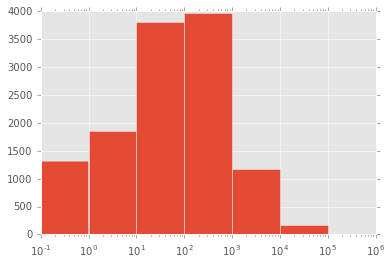

In [46]:
bins = np.logspace(-1, 6, 8)
#bins = 200
fig, ax = plt.pyplot.subplots()
trans_comb_add.value_ether.hist(ax=ax, bins=bins)
ax.set_xscale('log')
# ax.set_yscale('log')

In [13]:
grouped_ether = trans_comb_add.groupby('exp_group').sum()
grouped_accounts = trans_comb_add.groupby('exp_group').size()
grouped_accounts = pd.DataFrame(grouped_accounts, columns=['num_addresses'])

In [14]:
grouped_ether['value_perc'] = grouped_ether.value_ether / total_ether * 100
grouped_accounts['percentage'] = grouped_accounts.num_addresses / total_addresses * 100

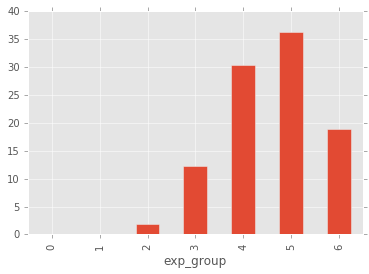

In [93]:
grouped_ether.value_perc.plot(kind='bar')

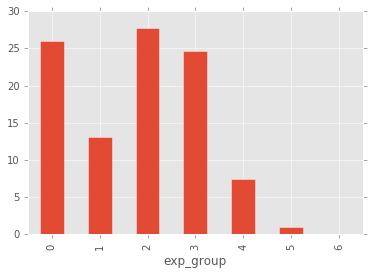

In [94]:
grouped_accounts.percentage.plot(kind='bar')

In [108]:
trace = go.Bar( 
    y=grouped_accounts.percentage,
    name='Total Accounts',
)
trace2 = go.Bar( 
    y=grouped_ether.value_perc,
    name='Total Ether Held',
)
data = Data([trace, trace2])
layout = go.Layout(
    xaxis=go.XAxis(
        title='Investor Group',
        ticktext = [
                "$0 < x < 10^0$",
                "$10^0 < x < 10^1$",
                "$10^1 < x < 10^2$",
                "$10^2 < x < 10^3$",
                "$10^3 < x < 10^4$",
                "$10^4 < x < 10^5$",
                "$10^5 < x < 10^6$",
            ],
        tickvals = [ 0, 1, 2, 3, 4, 5, 6 ]
    ),
    yaxis=go.YAxis(
        title='Percentage',
    ),
    legend=dict(
        x=0,
        y=1
    )
)
fig = go.Figure(data=data, layout=layout)

# iplot(fig)
py.iplot(fig, filename='DAO_plots/PercentageAccountsVsPercentageEther')